In [1]:
import csv
import numpy as np
import pandas as pd
import utils 
from copy import deepcopy
import seaborn as sns

from scipy.optimize import minimize, LinearConstraint
from scipy.special import softmax

In [2]:


def p_traj(a, s):
    '''
    Returns the probability of a sequence of actions
    a being sampled from strategy s.

    Paramters:
        a : (np.Array) 2 x n array of actions chosen
        s : (np.Array) 2 x n array of strategies 
    '''

    assert a.shape == s.shape
    L = a.shape[1]
    prod = 1
    for l in range(L):
        idx = np.where(a[:, l])
        prod *= s[:, l][idx][0]

    return prod


class Level_K_Model:
    def __init__(self, K):
        self.K = K
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -1]])
        
        
        
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -1]])
        self.alphas = None
      


    def log_likelihood_independent(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood. This assumes a players level may change as the game goes on

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        
        alphas = params[0:-2]
        lambda_ = params[-2] 
        kappa  = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                traj = play[player]
                other_traj  = play[1-player] # trajectory of other player
                
                pred_s = self.predict_traj(traj, other_traj, self.K, lambda_, kappa, overall=True, alphas=alphas)  
               
                L = traj.shape[1] #length of trajectory
                for l in range(L):
                    idx = np.where(traj[:, l])
                    ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood


    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:-2]
        lambda_ = params[-2] 
        kappa  = params[-1] 
       

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, k in enumerate(range(self.K+1)): # condition on a specific value of k for a player
                    alpha_k = alphas[i]
    
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    pred_s = self.predict_traj(traj, other_traj, k, lambda_, kappa)
                    
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    
                    sum += alpha_k * prob # this could be 0, so small epsilon added

                ll += np.log(sum)
                #print(np.log(sum))

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(self.K+3) # +2 since level 0 and the lambda parameter, kappa parameter
        params[0] = 1 # inital guess is that all players are level 0
        params[-2] = 5 # intial guess for lambda
        params[-1] = 0.5 # intial guess for kappa

        const_arr = np.ones(self.K+3)
        const_arr[-1] = 0
        const_arr[-2] = 0
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(self.K+1)]
        bnds.append((0, 1000)) 
        bnds.append((0, 1)) 

        result = minimize(
            self.log_likelihood_independent ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 

        assert result.status == 0 # make sure the optimization was successful
        return result


    def predict_traj(self, traj, other_traj, K, lambda_, kappa, overall=False, alphas=None):
        '''
        Returns straetgy predictions against other player
        
        '''
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h):
                l.append(l[i-1]*kappa)

            weight_left = 1- np.sum(l)
            l[0] = l[0] + weight_left
            
            l = np.flip(np.array(l))

            return l 

        L = other_traj.shape[1]
        pred_i = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for i
        pred_other = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for other player

        for l in range(L):
            # first determine level 0 strategy 
            start_hist_idx = 0 #max(l-self.h, 0)
            end_hist_idx = l

            if l == 0: # there is no history, so level-0 strategies are uniform
                lvl_0_s_i = np.ones((2)) / 2
                lvl_0_s_other = np.ones((2)) / 2
            else:
                hist_i = traj[:, start_hist_idx:end_hist_idx] # limited history of i's actions
                hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions

                w = get_weights(hist_i.shape[1], kappa)
                lvl_0_s_i =  0.999*np.dot(hist_i, w)+ 0.001 * np.ones((2))/2
                lvl_0_s_other=  0.999*np.dot(hist_other, w)+ 0.001 * np.ones((2))/2


            # These become the level 0 strategies
            pred_i[:, 0, l] = lvl_0_s_i
            pred_other[:, 0, l] = lvl_0_s_other

            # Now, for higher levels:
            for k in range(1, K+1):
                pred_i[:, k, l] = 0.999*self.compute_BR(pred_other[:, k-1, l], lambda_) + 0.001 * np.ones((2))/2
                pred_other[:, k, l] =  0.999*self.compute_BR(pred_i[:, k-1, l], lambda_)+ 0.001 * np.ones((2))/2
 

        if overall: # if return the overall prediction
            assert alphas is not None
            pred_i_ = np.zeros((2, L))

            for l in range(L):
                pred_i_[:, l] = np.dot(pred_i[:, :, l], alphas)
            pred_i = pred_i_
     
        else:
            pred_i = np.squeeze(pred_i[:, K, :]) # only return the level K predictions


        # if K == 0:
        #     return np.ones((2, L)) / (np.ones(L)*2)
        # else:
        return pred_i   


    def compute_BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


class Temporal_Level_Model:
    def __init__(self):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -2]])
        self.alphas = None
       


    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:3] # frequency of different reasoning types in the population
        
        gamma = params[-3]  # parameter for forward looking type
        lambda_ = params[-2] 
        kappa = params[-1] 
      

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for k, alpha_k in enumerate(alphas): # condition on a specific type of  player
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                  
                    pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa, k)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_k * (prob) # this could be 0, so small epsilon added
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


        # ll = 0
        # for play in dataset: 
        #     for player in range(2):
        #         traj = play[player]
        #         other_traj  = play[1-player] # trajectory of other player    
        #         pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa)
                   
        #         L = traj.shape[1] #length of trajectory
        #         for l in range(L):
        #             idx = np.where(traj[:, l])
        #             ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(6) # +2 since level 0 and the lambda parameter
    
        for i in range(3):
            params[i] = 1/3

        params[3] = 0.5 #gamma 
        params[4] = 1 # lambda
        params[5] = 0.5 # kappa

        const_arr = np.zeros(6)
        for i in range(3):
            const_arr[i] = 1
       
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(3)]
       
        bnds.append((0, 1)) 
        bnds.append((0, 1000)) # lambda
        bnds.append((0, 1)) 
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
        #print(result)

        assert result.status == 0 # make sure the optimization was successful
        return result
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma, alphas, kappa, k): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''


        L = other_traj.shape[1]
        pred_i = np.zeros((2, len(alphas), L)) # level-k prediction for each stage game for 
        
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h):
                l.append(l[i-1]*kappa)

            weight_left = 1- np.sum(l)
            l[0] = l[0] + weight_left
            
            l = np.flip(np.array(l))

            return l 

        for l in range(L):
            for k in range(len(alphas)):
                if k == 0:
                    pred_i[:, k, l] = np.ones(2)/2

                if k == 1:
                    
                    if l == 0:
                        # if action 0                   
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) 
                        # if action 1                 
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0])
                
                    else:
                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
                        s_other_curr = self.BR(np.dot(hist, w), lambda_)
                        # if action 0
                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0])
                        # if action 1
                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) 

                    
                    pred_i[:, k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

                if k == 2:
                    if l == 0:
                        # if action 0
                        s_other_next = self.BR(np.array([1,0]), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1
                        s_other_next = self.BR(np.array([0,1]), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
                
                    else:
                        # if action 0

                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
        
                        s_other_curr = self.BR(np.dot(hist, w), lambda_)

                        hist_new = np.c_[hist, np.array([1,0]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)

                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1

                        hist_new = np.c_[hist, np.array([0,1]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_)
                        s_i_next = self.BR(s_other_next, lambda_)

                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                    pred_i[:,k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))


        pred_i_ = np.zeros((2, L))

        # for l in range(L):
        #     pred_i_[:, l] = np.dot(pred_i[:, :, l], alphas)
        # pred_i = pred_i_

        pred_i = np.squeeze(pred_i[:, k, :])
        
        return pred_i   


    def BR(self,  s_other, lambda_):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy profile of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0])

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0])

        return softmax(np.array([eu_0, eu_1])*lambda_)


class Level_K_Model_Payoffs:
    def __init__(self, K):
        self.K = K
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -2]])
        self.alphas = None


    def log_likelihood_independent(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood. This assumes a players level may change as the game goes on

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        
        alphas = params[0:self.K+1]
        changes = params[self.K+1: self.K+5]

        lambda_ = params[-2] 
        kappa  = params[-1] 

        ll = 0
        for play in dataset: 
            for player in range(2):
                traj = play[player]
                other_traj  = play[1-player] # trajectory of other player
                
                pred_s = self.predict_traj(traj, other_traj, self.K, lambda_, kappa, overall=True, alphas=alphas, changes=changes)  
               
                L = traj.shape[1] #length of trajectory
                for l in range(L):
                    idx = np.where(traj[:, l])
                    ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood


    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:self.K+1]
        changes = params[self.K+1: self.K+5]

        lambda_ = params[-2] 
        kappa  = params[-1] 


        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for i, k in enumerate(range(self.K+1)): # condition on a specific value of k for a player
                    alpha_k = alphas[i]
    
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                    pred_s = self.predict_traj(traj, other_traj, k, lambda_, kappa, changes=changes)  
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_k * prob # this could be 0, so small epsilon added

                if sum <= 0:
                    sum = 0.01
                ll += np.log(sum)


        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(self.K+7) # +2 since level 0 and the lambda parameter, kappa parameter
        params[0] = 1 # inital guess is that all players are level 0
        params[-2] = 5 # intial guess for lambda
        params[-1] = 0.5 # intial guess for kappa

        const_arr = np.ones(self.K+7)
        
        for i in range(self.K+1, self.K+7):
            const_arr[i] = 0
       
   
        constraint = LinearConstraint(const_arr, lb=1, ub=1)

        bnds = [(0, 1) for x in range(self.K+1)]
        # boudnds for payoff transformaitons
        bnds += [(-1, 1) for x in range(4)]

        
        # bounds for lambda and kappa
        bnds.append((0, 1000)) 
        bnds.append((0, 1)) 
        #print(bnds)

        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 

        assert result.status == 0 # make sure the optimization was successful

        return result


    def predict_traj(self, traj, other_traj, K, lambda_, kappa, overall=False, alphas=None, changes=None):
        '''
        Returns straetgy predictions against other player
        
        '''
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h):
                l.append(l[i-1]*kappa)

            weight_left = 1- np.sum(l)
            l[0] = l[0] + weight_left
            
            l = np.flip(np.array(l))

            return l 

        L = other_traj.shape[1]
        pred_i = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for i
        pred_other = np.zeros((2, self.K+1, L)) # level-k prediction for each stage game for other player

        for l in range(L):
            # first determine level 0 strategy 
            start_hist_idx = 0 #max(l-self.h, 0)
            end_hist_idx = l

            if l == 0: # there is no history, so level-0 strategies are uniform
                lvl_0_s_i = np.ones((2)) / 2
                lvl_0_s_other = np.ones((2)) / 2
            else:
                hist_i = traj[:, start_hist_idx:end_hist_idx] # limited history of i's actions
                hist_other = other_traj[:, start_hist_idx:end_hist_idx] # limited history of -i's actions

                w = get_weights(hist_i.shape[1], kappa)
                lvl_0_s_i =  0.999*np.dot(hist_i, w)+ 0.001 * np.ones((2))/2
                lvl_0_s_other=  0.999*np.dot(hist_other, w)+ 0.001 * np.ones((2))/2


            # These become the level 0 strategies
            pred_i[:, 0, l] = lvl_0_s_i
            pred_other[:, 0, l] = lvl_0_s_other

            # Now, for higher levels:
            for k in range(1, K+1):
                pred_i[:, k, l] = 0.999*self.compute_BR(pred_other[:, k-1, l], lambda_, change=changes) + 0.001 * np.ones((2))/2
                pred_other[:, k, l] =  0.999*self.compute_BR(pred_i[:, k-1, l], lambda_, change=changes)+ 0.001 * np.ones((2))/2
 

        if overall: # if return the overall prediction
            assert alphas is not None
            pred_i_ = np.zeros((2, L))

            for l in range(L):
                #pred_i[:, 0, l] = np.ones((2)) / 2
                pred_i_[:, l] = np.dot(pred_i[:, :, l], alphas)
            pred_i = pred_i_
     
        else:
            pred_i = np.squeeze(pred_i[:, K, :]) # only return the level K predictions
            
        return pred_i   


    def compute_BR(self,  s_other, lambda_, change=None):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0

        if change is None:
            change = np.zeros_like(self.payoffs[0])
        else:
            change = np.reshape(change, (2,2))
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0]+ change)

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0]+change)

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


class Temporal_Level_Model_Payoffs:
    def __init__(self):
        self.payoffs = np.zeros([2, 2, 2])
        self.payoffs[0, :, :] = np.array([[0, -1],
                                          [1, -2]])
        self.payoffs[1, :, :] = np.array([[0, 1],
                                         [-1, -2]])
        self.alphas = None
       


    def log_likelihood(self, params, dataset):
        '''
        Given the dataset and the fitted model, returns the log likelihood.

        NOTE: assumes each player has a fixed level
        
        Parameters:
            params : np.array of alpha_ks, the freq of that level in population and lambda_ for QBR
            dataset : list of plays, each play is an np array
        Returns:
            ll : loglikelihood of dataset

        '''
        alphas = params[0:3] # frequency of different reasoning types in the population
        change = params[3:7] # delta on payoffs
        
        gamma = params[-3]  # parameter for forward looking type
        lambda_ = params[-2] 
        kappa = params[-1] 
      

        ll = 0
        for play in dataset: 
            for player in range(2):
                sum = 0
                for k, alpha_k in enumerate(alphas): # condition on a specific type of  player
                    traj = play[player]
                    other_traj  = play[1-player] # trajectory of other player
                  
                    pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa, k, change)
                    prob = p_traj(traj, pred_s) # probability of that trajectory
                    sum += alpha_k * (prob) # this could be 0, so small epsilon added
                ll += np.log(sum)

        return -ll # since we are minimizing the negative log likelihood


        # ll = 0
        # for play in dataset: 
        #     for player in range(2):
        #         traj = play[player]
        #         other_traj  = play[1-player] # trajectory of other player    
        #         pred_s = self.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa)
                   
        #         L = traj.shape[1] #length of trajectory
        #         for l in range(L):
        #             idx = np.where(traj[:, l])
        #             ll += np.log(pred_s[:, l][idx][0])

        return -ll # since we are minimizing the negative log likelihood


    def fit(self, dataset):
        params = np.zeros(10) 
    
        for i in range(3):
            params[i] = 1/3

        params[-3] = 0.5 # gamma 
        params[-2] = 1 # lambda
        params[-1] = 0.5 # kappa

        const_arr = np.zeros(10)
        for i in range(3):
            const_arr[i] = 1
       
        constraint = LinearConstraint(const_arr, lb=1, ub=1)
        bnds = [(0, 1) for x in range(3)] # type params

        # payoffs transform
        bnds.append((-1, 1)) 
        bnds.append((-1, 1)) 
        bnds.append((-1, 1)) 
        bnds.append((-1, 1)) 
       
        bnds.append((0, 1)) # gamma 
        bnds.append((0, 1000)) # lambda
        bnds.append((0, 1)) # kappa
       
        result = minimize(
            self.log_likelihood ,
            params, 
            args=(dataset),
            bounds=bnds, 
            constraints=constraint) 
       
        return result
    
        
    def predict_traj(self, traj, other_traj, lambda_, gamma, alphas, kappa, k, change): 
        '''
        I think about what action I can take

        what do I think you will play this round? 
        -> probably a best response to my last action

        what do I think you will play next round?
        -> probably a brest resonse to this aciton

        what will I play next round? 
            -> probably a best resonse to what I think you will play next round
        '''


        L = other_traj.shape[1]
        pred_i = np.zeros((2, len(alphas), L)) # level-k prediction for each stage game for 
        
        def get_weights(h, kappa):
            if h == 1:
                return np.ones(1)
            
            l = [1-kappa]
            for i in range(1, h):
                l.append(l[i-1]*kappa)

            weight_left = 1- np.sum(l)
            l[0] = l[0] + weight_left
            
            l = np.flip(np.array(l))

            return l 

        for l in range(L):
            for k in range(len(alphas)):
                if k == 0:
                    pred_i[:, k, l] = np.ones(2)/2

                if k == 1:
                    
                    if l == 0:
                        # if action 0                   
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) 
                        # if action 1                 
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0])
                
                    else:
                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
                        s_other_curr = self.BR(np.dot(hist, w), lambda_, change)
                        # if action 0
                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0])
                        # if action 1
                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) 

                    
                    pred_i[:, k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

                if k == 2:
                    if l == 0:
                        # if action 0
                        s_other_next = self.BR(np.array([1,0]), lambda_,  change)
                        s_i_next = self.BR(s_other_next, lambda_,  change)
                        eu_0 = expected_utility([np.array([1,0]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1
                        s_other_next = self.BR(np.array([0,1]), lambda_,  change)
                        s_i_next = self.BR(s_other_next, lambda_,  change)
                        eu_1 =  expected_utility([np.array([0,1]), np.array([0.5, 0.5])], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])
                
                    else:
                        # if action 0

                        hist = traj[:, 0:l]
                        w = get_weights(hist.shape[1], kappa)
        
                        s_other_curr = self.BR(np.dot(hist, w), lambda_,  change)

                        hist_new = np.c_[hist, np.array([1,0]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_,  change)
                        s_i_next = self.BR(s_other_next, lambda_,  change)

                        eu_0 = expected_utility([np.array([1,0]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                        # if action 1

                        hist_new = np.c_[hist, np.array([0,1]) ]
                        w = get_weights(hist_new.shape[1], kappa)
                        s_other_next = self.BR(np.dot(hist_new, w), lambda_,  change)
                        s_i_next = self.BR(s_other_next, lambda_,  change)

                        eu_1 = expected_utility([np.array([0,1]), s_other_curr], self.payoffs[0]) + gamma*expected_utility([s_i_next, s_other_next], self.payoffs[0])

                    pred_i[:,k, l]  = softmax(lambda_* np.array([eu_0, eu_1]))

        pred_i = np.squeeze(pred_i[:, k, :])
        
        return pred_i   


    def BR(self,  s_other, lambda_, change=None):
        '''
        Computes a best response

        Parameters:
            s_other : (np.Array) strategy of other player

        NOTE: this ONLY works with symetric payoffs and 2 actions
        '''
    
        #get EU of action 0

        if change is None:
            change = np.zeros_like(self.payoffs[0])
        else:
            change = np.reshape(change, (2,2))
    
        s = [np.array([1, 0]), s_other]
        eu_0 = expected_utility(s, self.payoffs[0]+ change)

        # get EU of action 1
        s = [np.array([0, 1]), s_other]
        eu_1 = expected_utility(s, self.payoffs[0]+change)

        # return action with greater EU
        return softmax(np.array([eu_0, eu_1])*lambda_)


In [254]:
data = np.genfromtxt('data_new.csv', delimiter=',', dtype=str)
data = np.delete(data, 0, 0)
new_data = []

# turn each game into entry in this array

def remove_blank(l):
    return list(filter(lambda a: a != '', l))

def replace_letters(l):
   return [[1,0] if x=='c' else [0, 1] for x in l]

for i in range(0, data.shape[0], 2):
    p1 = data[i]
    p2 = data[i+1]

    game = int(p1[0])
    player1 = p1[2]
    player2 = p2[2]
    p1_actions = np.array(replace_letters(remove_blank(p1[3:]))).T
    p2_actions =  np.array(replace_letters(remove_blank(p2[3:]))).T
   
    actions =  [p1_actions, p2_actions]

    new_data.append([game, player1, player2, actions])

df = pd.DataFrame(new_data)
df.columns = ['Game', 'Player_1', 'Player_2', 'Actions']

In [5]:
df.head()

,Game,Player_1,Player_2,Actions
0,0,Faisal,Bharathvaj,"[[[0, 1, 1, 1, 0], [1, 0, 0, 0, 1]], [[1, 0, 1..."
1,1,Yuan,Dagmar,"[[[1, 0, 0], [0, 1, 1]], [[1, 1, 0], [0, 0, 1]]]"
2,2,Ehsan,Mohammend,"[[[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0,..."
3,3,Tao,Rohini,"[[[0, 1, 0, 1, 1], [1, 0, 1, 0, 0]], [[1, 0, 0..."
4,4,Anita,Greg,"[[[1, 1, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 1]..."


In [255]:
data = list(df.Actions)

In [7]:
from tqdm import tqdm

In [8]:
def ll_uniform(dataset):
    ll = 0
    for play in dataset: 
        for player in range(2):
            traj = play[player]
            s = np.ones(2) / 2
            
            L = traj.shape[1] #length of trajectory
            for l in range(L):
                idx = np.where(traj[:, l])
                ll += np.log(s[idx[0][0]])
        
    return -ll

In [9]:
def k_folds(data, m):
    results = []
    test_losses = []
    for i in range(len(data)):
        train_data = deepcopy(data)
        test_data = deepcopy(train_data[i])
        del train_data[i]

        res = m.fit(train_data)
        params = res.x
        test_loss = m.log_likelihood(params, [test_data])
        results.append(res)
        test_losses.append(test_loss)

    return results, test_losses


In [217]:
# K-folds on level k
all_lk = []
for k in tqdm(range(0, 4)):
    m = Level_K_Model(k)
    results_LK, LL_LK =  k_folds(data, m)
    all_lk.append([results_LK, LL_LK])
        

100%|██████████| 4/4 [04:02<00:00, 60.61s/it]


In [218]:
# K-folds on level k 
all_lkp= []
for k in tqdm(range(0, 4)):
    m = Level_K_Model_Payoffs(k)
    results_LKP, LL_LKP =  k_folds(data, m)
    all_lkp.append([results_LKP, LL_LKP])

100%|██████████| 4/4 [17:16<00:00, 259.16s/it]


In [12]:
m = Temporal_Level_Model()
results_TLM, LL_TLM = k_folds(data, m)
        

In [35]:
m = Temporal_Level_Model_Payoffs()
results_TLMP, LL_TLMP = k_folds(data, m)

In [197]:
# results on all train data
# K-folds on level k
results = []
models = []

for k in tqdm(range(1, 4)):
    m = Level_K_Model(k)
    r = m.fit(data)
    results.append(r)
    models.append(m)


for k in tqdm(range(1, 4)):
    m = Level_K_Model_Payoffs(k)
    r = m.fit(data)
    results.append(r)
    models.append(m)
    
m =  Temporal_Level_Model()
r = m.fit(data)
results.append(r)
models.append(m)

m =  Temporal_Level_Model_Payoffs()
r = m.fit(data)
results.append(r)
models.append(m)


100%|██████████| 3/3 [01:19<00:00, 26.63s/it]


In [38]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

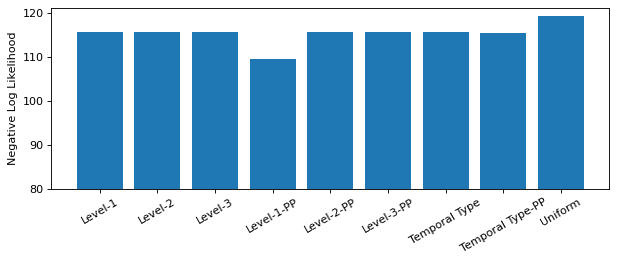

In [198]:
figure(figsize=(9, 3), dpi=80)

start = 80
plt.bar( range(len(results)+1),  [r.fun-start  for r in results] + [ll_uniform(data)-start ], bottom=start )
plt.ylabel("Negative Log Likelihood")

# locs, labels = plt.xticks()

labels =  [ 'Level-{}'.format(k) for k in range(1, 4)] + [ 'Level-{}-PP'.format(k) for k in range(1, 4)]
labels += ['Temporal Type', 'Temporal Type-PP', 'Uniform']
plt.xticks(range(9), labels , rotation=30  )

plt.savefig('figures/ll_train.pdf', bbox_inches='tight')

In [57]:
#uniform
results_uniform = []
test_losses_uniform = []
for i in range(len(data)):
    train_data = deepcopy(data)
    test_data = deepcopy(train_data[i])
    del train_data[i]

    results_uniform.append(ll_uniform(train_data))
    test_losses_uniform.append(ll_uniform([test_data]))

In [219]:
len(all_lkp )

4

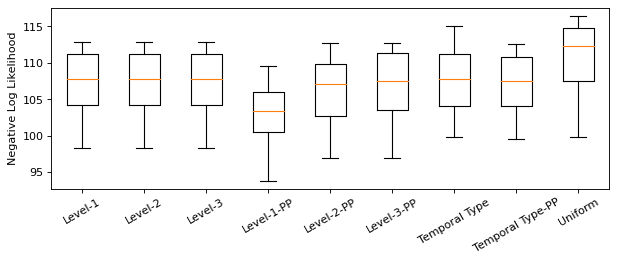

In [220]:
all_results = deepcopy(all_lk + all_lkp + [[results_TLM, LL_TLM], [results_TLMP, LL_TLMP]] )

del all_results[4]
del all_results[0]
plot_data = []
for r in all_results:
    result_list = r[0]


    train_losses = [x.fun for x in result_list]

    plot_data.append(train_losses)

plot_data.append(results_uniform)

figure(figsize=(9, 3), dpi=80)
plt.boxplot(plot_data)
plt.ylabel("Negative Log Likelihood")

labels =  [ 'Level-{}'.format(k) for k in range(1, 4)] + [ 'Level-{}-PP'.format(k) for k in range(1, 4)]
labels += ['Temporal Type', 'Temporal Type-PP', 'Uniform']
plt.xticks(range(1, 10), labels , rotation=30  )

plt.savefig('figures/ll_train_cross.pdf', bbox_inches='tight')

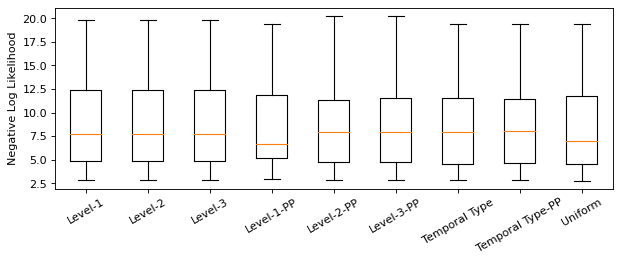

In [221]:
all_results = deepcopy(all_lk + all_lkp + [[results_TLM, LL_TLM], [results_TLMP, LL_TLMP]] )

del all_results[4]
del all_results[0]

plot_data = []
for r in all_results:
    result_list = r[1]
    plot_data.append(result_list)

plot_data.append(test_losses_uniform)
figure(figsize=(9, 3), dpi=80)
plt.boxplot(plot_data)
plt.ylabel("Negative Log Likelihood")

labels =  [ 'Level-{}'.format(k) for k in range(1, 4)] + [ 'Level-{}-PP'.format(k) for k in range(1, 4)]
labels += ['Temporal Type', 'Temporal Type-PP', 'Uniform']
plt.xticks(range(1, 10), labels , rotation=30  )

plt.savefig('figures/ll_test_cross.pdf', bbox_inches='tight')

In [319]:
K= 1
m = Level_K_Model_Payoffs(K)
r = m.fit(data)
params = r.x

In [314]:
params

array([2.76339498e-01, 7.23660502e-01, 4.20473161e-12, 8.43039788e-01])

In [2]:
def predict_empirically(traj, other_traj, data):
    '''
    what happens after traj, other_traj empircially?
    '''
    s_0 = np.zeros(2)
    s_1 = np.zeros(2)


    for play in data:
        traj_len = traj.shape[1]
        play_len =  play[0].shape[1]
        if  traj_len >= play_len:
            continue

        for player in range(2):
            for end_idx in range(traj_len, play_len):
        
                play_0 = play[player][:, end_idx-traj_len:end_idx]
                play_1 = play[1-player][:, end_idx-traj_len:end_idx]
                if np.array_equal(play_0, traj) and np.array_equal(play_1, other_traj):
                    s_0 += play[player][:, end_idx]
                    s_1 += play[1-player][:, end_idx]


    return [s_0/np.sum(s_0), s_1/np.sum(s_1)], np.sum(s_1)


In [3]:
data = utils.load_data('data_new.csv')

In [5]:
trajs = [
    np.array([[1, 1],
              [0, 0]]),
    np.array([[1, 0],
              [0, 1]]),
    np.array([[0, 1],
              [1, 0]]),
    np.array([[0, 0],
              [1, 1]])]

for t_1 in trajs:
    for t_2 in trajs:

        empirical_p, num_matches = predict_empirically(t_1, t_2, data)


        if num_matches != 0:
            print(t_1)
            print(t_2)
            print(empirical_p)
            print("")

[[1 1]
 [0 0]]
[[1 1]
 [0 0]]
[array([0.61111111, 0.38888889]), array([0.61111111, 0.38888889])]

[[1 1]
 [0 0]]
[[1 0]
 [0 1]]
[array([0.16666667, 0.83333333]), array([0.5, 0.5])]

[[1 1]
 [0 0]]
[[0 1]
 [1 0]]
[array([0.5, 0.5]), array([0.875, 0.125])]

[[1 1]
 [0 0]]
[[0 0]
 [1 1]]
[array([0.66666667, 0.33333333]), array([1., 0.])]

[[1 0]
 [0 1]]
[[1 1]
 [0 0]]
[array([0.5, 0.5]), array([0.16666667, 0.83333333])]

[[1 0]
 [0 1]]
[[1 0]
 [0 1]]
[array([0., 1.]), array([0., 1.])]

[[1 0]
 [0 1]]
[[0 1]
 [1 0]]
[array([0.61538462, 0.38461538]), array([0.38461538, 0.61538462])]

[[1 0]
 [0 1]]
[[0 0]
 [1 1]]
[array([0.33333333, 0.66666667]), array([0.33333333, 0.66666667])]

[[0 1]
 [1 0]]
[[1 1]
 [0 0]]
[array([0.875, 0.125]), array([0.5, 0.5])]

[[0 1]
 [1 0]]
[[1 0]
 [0 1]]
[array([0.38461538, 0.61538462]), array([0.61538462, 0.38461538])]

[[0 1]
 [1 0]]
[[0 1]
 [1 0]]
[array([1., 0.]), array([1., 0.])]

[[0 1]
 [1 0]]
[[0 0]
 [1 1]]
[array([0.33333333, 0.66666667]), array([0.33333

In [316]:
def predict(traj, other_traj, params, m, K):
   
    alphas = params[0:m.K+1]
    changes = params[m.K+1: m.K+5]
    lambda_ = params[-2] 
    kappa  = params[-1] 

    s_0 = np.zeros(2)
    s_1 = np.zeros(2)
    for k in range(K+1):
        if traj.shape[1] == 1:
            s_0 += alphas[k] *  m.predict_traj(traj, other_traj, k, lambda_,  kappa, changes = changes )
        else:
            s_0 += alphas[k] *  m.predict_traj(traj, other_traj,  k, lambda_,  kappa, changes = changes )[:, -1]

    for k in range(K+1):
        if traj.shape[1] == 1:
            s_1 += alphas[k] *  m.predict_traj(other_traj, traj, k, lambda_,  kappa, changes = changes )
        else:

            s_1 += alphas[k] *  m.predict_traj(other_traj, traj, k, lambda_,  kappa, changes = changes )[:, -1]

    return s_0, s_1

In [320]:
# iterative prediciton 

traj = np.ones((2, 1))/2
other_traj = np.ones((2, 1))/2

for i in range(5):
    s_0, s_1 = predict(traj, other_traj, params, m, K)

    traj[:, -1] =  s_0
    traj = np.c_[traj, np.ones(2)/2  ]

    other_traj[:, -1] =  s_1
    other_traj = np.c_[other_traj, np.ones(2)/2  ]
    

In [207]:
traj

array([[0.51356198, 0.52035047, 0.52291335, 0.52421863, 0.52507238,
        0.5       ],
       [0.48643802, 0.47964953, 0.47708665, 0.47578137, 0.47492762,
        0.5       ]])

In [208]:
other_traj

array([[0.51356198, 0.52035047, 0.52291335, 0.52421863, 0.52507238,
        0.5       ],
       [0.48643802, 0.47964953, 0.47708665, 0.47578137, 0.47492762,
        0.5       ]])

In [321]:
trajs = [
    np.array([[1, 1],
              [0, 0]]),
    np.array([[1, 0],
              [0, 1]]),
    np.array([[0, 1],
              [1, 0]]),
    np.array([[0, 0],
              [1, 1]])]

for t_1 in trajs:
    for t_2 in trajs:

        model_p = predict(np.c_[t_1, np.zeros(2)], np.c_[t_2, np.zeros(2)], params, m, K)
        empirical_p, num_matches = predict_empirically(t_1, t_2, gen_data)


        if num_matches != 0:
            print(t_1)
            print(t_2)
            print(empirical_p)
            print(model_p)
            print("")

[[1 1]
 [0 0]]
[[0 0]
 [1 1]]
[array([0., 1.]), array([0., 1.])]
(array([0.30513865, 0.69486135]), array([0.71644275, 0.28355725]))

[[1 0]
 [0 1]]
[[0 1]
 [1 0]]
[array([1., 0.]), array([0., 1.])]
(array([0.6238179, 0.3761821]), array([0.40170098, 0.59829902]))

[[0 1]
 [1 0]]
[[1 0]
 [0 1]]
[array([0., 1.]), array([1., 0.])]
(array([0.40170098, 0.59829902]), array([0.6238179, 0.3761821]))

[[0 0]
 [1 1]]
[[1 1]
 [0 0]]
[array([0., 1.]), array([0., 1.])]
(array([0.71644275, 0.28355725]), array([0.30513865, 0.69486135]))



/var/folders/v7/0vkjh6x108b272crch0w9glh0000gp/T/ipykernel_18165/3780517756.py:25: RuntimeWarning: invalid value encountered in true_divide
  return [s_0/np.sum(s_0), s_1/np.sum(s_1)], np.sum(s_1)


In [243]:
def predict_tt(traj, other_traj, params, m, K):
   
    alphas = params[0:3] # frequency of different reasoning types in the population
    change = params[3:7] # delta on payoffs
    
    gamma = params[-3]  # parameter for forward looking type
    lambda_ = params[-2] 
    kappa = params[-1] 
    
    print(alphas)

    s_0 = np.zeros(2)
    s_1 = np.zeros(2)
    for k in range(K+1):
        if traj.shape[1] == 1:
            s_0 += alphas[k] *  m.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa, k, change)
        else:
            s_0 += alphas[k] *  m.predict_traj(traj, other_traj, lambda_, gamma, alphas, kappa, k, change)[:, -1]

    for k in range(K+1):
        if traj.shape[1] == 1:
            s_1 += alphas[k] *  m.predict_traj(other_traj, traj, lambda_, gamma, alphas, kappa, k, change)
        else:

            s_1 += alphas[k] *  m.predict_traj(other_traj, traj, lambda_, gamma, alphas, kappa, k, change)[:, -1]

    return [s_0, s_1]

In [252]:

m = Temporal_Level_Model_Payoffs()
r = m.fit(data)
params = r.x

IndexError: tuple index out of range

In [246]:
params

array([ 3.33334686e-01,  3.33330629e-01,  3.33334686e-01, -1.00000000e+00,
        4.66779983e-01,  1.00000000e+00, -4.66721213e-01,  4.20227838e-16,
        7.87934029e-01,  7.71920191e-01])

In [238]:
# iterative prediciton 

traj = np.ones((2, 1))/2
other_traj = np.ones((2, 1))/2

for i in range(5):
    s_0, s_1 = predict_tt(traj, other_traj, params, m, 2)
    

    traj[:, -1] =  s_0
    traj = np.c_[traj, np.ones(2)/2  ]

    other_traj[:, -1] =  s_1
    other_traj = np.c_[other_traj, np.ones(2)/2  ]

In [239]:
traj

array([[0.5       , 0.54069436, 0.55269471, 0.55614864, 0.55757798,
        0.5       ],
       [0.5       , 0.45930564, 0.44730529, 0.44385136, 0.44242202,
        0.5       ]])

In [240]:
other_traj

array([[0.5       , 0.54069436, 0.55269471, 0.55614864, 0.55757798,
        0.5       ],
       [0.5       , 0.45930564, 0.44730529, 0.44385136, 0.44242202,
        0.5       ]])

In [247]:
trajs = [
    np.array([[1, 1],
              [0, 0]]),
    np.array([[1, 0],
              [0, 1]]),
    np.array([[0, 1],
              [1, 0]]),
    np.array([[0, 0],
              [1, 1]])]

for t_1 in trajs:
    for t_2 in trajs:

        model_p = predict_tt(np.c_[t_1, np.zeros(2)], np.c_[t_2, np.zeros(2)], params, m, 2)
        empirical_p, num_matches = predict_empirically(t_1, t_2, gen_data)


        if num_matches != 0:
            print(t_1)
            print(t_2)
            print(empirical_p)
            print(model_p)
            print("")

[0.33333469 0.33333063 0.33333469]
[[1 1]
 [0 0]]
[[1 1]
 [0 0]]
[array([0.625, 0.375]), array([0.625, 0.375])]
[array([0.6575621, 0.3424379]), array([0.6575621, 0.3424379])]

[0.33333469 0.33333063 0.33333469]
[[1 1]
 [0 0]]
[[1 0]
 [0 1]]
[array([0.2, 0.8]), array([0.6, 0.4])]
[array([0.6575621, 0.3424379]), array([0.42251691, 0.57748309])]

[0.33333469 0.33333063 0.33333469]
[[1 1]
 [0 0]]
[[0 1]
 [1 0]]
[array([0.5, 0.5]), array([0.875, 0.125])]
[array([0.6575621, 0.3424379]), array([0.63187043, 0.36812957])]

[0.33333469 0.33333063 0.33333469]
[[1 1]
 [0 0]]
[[0 0]
 [1 1]]
[array([0.66666667, 0.33333333]), array([1., 0.])]
[array([0.6575621, 0.3424379]), array([0.37614788, 0.62385212])]

[0.33333469 0.33333063 0.33333469]
[[1 0]
 [0 1]]
[[1 1]
 [0 0]]
[array([0.6, 0.4]), array([0.2, 0.8])]
[array([0.42251691, 0.57748309]), array([0.6575621, 0.3424379])]

[0.33333469 0.33333063 0.33333469]
[0.33333469 0.33333063 0.33333469]
[[1 0]
 [0 1]]
[[0 1]
 [1 0]]
[array([0.625, 0.375]), arra

/var/folders/v7/0vkjh6x108b272crch0w9glh0000gp/T/ipykernel_18165/3780517756.py:25: RuntimeWarning: invalid value encountered in true_divide
  return [s_0/np.sum(s_0), s_1/np.sum(s_1)], np.sum(s_1)


# Generalization

In [264]:
gen_data = np.genfromtxt('general_data.csv', delimiter=',', dtype=str)
gen_data = np.delete(gen_data, 0, 0)
new_data = []

# turn each game into entry in this array

def remove_blank(l):
    return list(filter(lambda a: a != '', l))

def replace_letters(l):
   return [[1,0] if x=='c' else [0, 1] for x in l]

for i in range(0, gen_data.shape[0], 2):
    p1 = gen_data[i]
    p2 = gen_data[i+1]

    game = int(p1[0])
    player1 = p1[2]
    player2 = p2[2]
    p1_actions = np.array(replace_letters(remove_blank(p1[3:]))).T
    p2_actions =  np.array(replace_letters(remove_blank(p2[3:]))).T
   
    actions =  [p1_actions, p2_actions]

    new_data.append([game, player1, player2, actions])

df = pd.DataFrame(new_data)
df.columns = ['Game', 'Player_1', 'Player_2', 'Actions']

In [265]:
gen_data = list(df.Actions)


In [266]:
gen_data

[[array([[0, 0, 0],
         [1, 1, 1]]),
  array([[1, 1, 0],
         [0, 0, 1]])],
 [array([[1, 1],
         [0, 0]]),
  array([[1, 0],
         [0, 1]])],
 [array([[0, 1, 0, 1],
         [1, 0, 1, 0]]),
  array([[1, 0, 1, 0],
         [0, 1, 0, 1]])],
 [array([[0, 1, 0, 1, 0],
         [1, 0, 1, 0, 1]]),
  array([[1, 0, 1, 0, 1],
         [0, 1, 0, 1, 0]])],
 [array([[0, 0],
         [1, 1]]),
  array([[0, 0],
         [1, 1]])]]

In [267]:
m = Temporal_Level_Model_Payoffs()
r = m.fit(data)
params = r.x

m.log_likelihood(params, gen_data)

25.06205384874498

In [268]:
m = Level_K_Model_Payoffs(1)
r = m.fit(data)
params = r.x

m.log_likelihood(params, gen_data)

19.429507866084904

In [270]:
ll_uniform(gen_data)

22.180709777918235

In [310]:
# results on all train data
# K-folds on level k
results = []
models = []

for k in tqdm(range(1, 4)):
    m = Level_K_Model(k)
    r = m.fit(data)
    results.append(m.log_likelihood(params, gen_data))


for k in tqdm(range(1, 4)):
    m = Level_K_Model_Payoffs(k)
    r = m.fit(data)
    results.append(m.log_likelihood(params, gen_data))
    
m =  Temporal_Level_Model()
r = m.fit(data)
results.append(m.log_likelihood(params, gen_data))

m =  Temporal_Level_Model_Payoffs()
r = m.fit(data)
results.append(m.log_likelihood(params, gen_data))


100%|██████████| 3/3 [01:21<00:00, 27.04s/it]


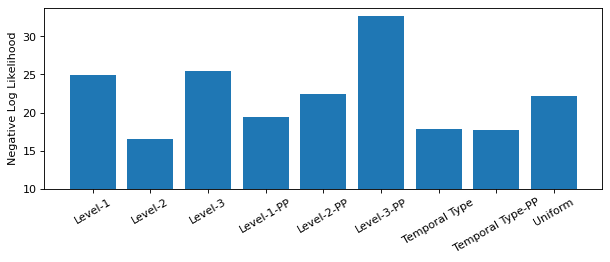

In [312]:
figure(figsize=(9, 3), dpi=80)

start = 10
plt.bar( range(len(results)+1),  [r-start  for r in results] + [ll_uniform(gen_data)-start ], bottom=start )
plt.ylabel("Negative Log Likelihood")

# locs, labels = plt.xticks()

labels =  [ 'Level-{}'.format(k) for k in range(1, 4)] + [ 'Level-{}-PP'.format(k) for k in range(1, 4)]
labels += ['Temporal Type', 'Temporal Type-PP', 'Uniform']
plt.xticks(range(9), labels , rotation=30  )

plt.savefig('figures/ll_generalization.pdf', bbox_inches='tight')